In [3]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [4]:
[[raw_train_ds, raw_val_ds, raw_test_ds], info] = tfds.load('speech_commands', split=['train', 'validation', 'test'], shuffle_files=True, as_supervised=True, with_info=True)

labels = info.features['label'].names
num_classes = info.features['label'].num_classes

print('labels:', labels)

labels: ['down', 'go', 'left', 'no', 'off', 'on', 'right', 'stop', 'up', 'yes', '_silence_', '_unknown_']


In [6]:
for audio, _ in raw_train_ds.take(1):
    print(audio)

tf.Tensor([-25 -36 -47 ... -81 -69 -60], shape=(16000,), dtype=int64)


In [7]:
def get_waveform_and_label(audio, label):
    waveform = tf.cast(audio, tf.float32)
    min = tf.reduce_min(waveform)
    max = tf.reduce_max(waveform)
    mean = tf.reduce_mean(waveform)
    
    scale = (2 / (max - min)) * 0.9
    offset = -(mean * scale)
    
    waveform = waveform * scale + offset
    return waveform, label

In [8]:
AUTOTUNE = tf.data.AUTOTUNE

waveform_train_ds = raw_train_ds.map(
    map_func=get_waveform_and_label,
    num_parallel_calls=AUTOTUNE)

for waveform, _ in waveform_train_ds.take(1):    
    print(waveform)

tf.Tensor(
[-0.00111185 -0.00799206 -0.01494107 ... -0.00854248 -0.01053774
 -0.01198258], shape=(16000,), dtype=float32)


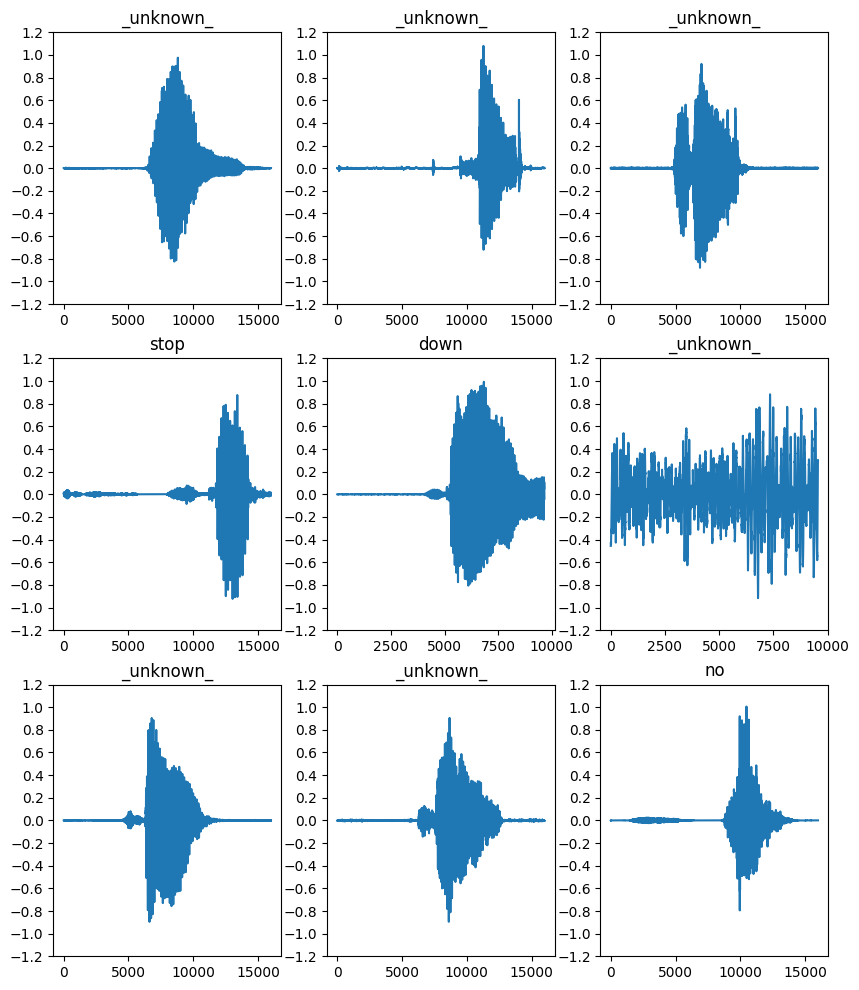

In [9]:
rows = 3
cols = 3
n = rows * cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 12))

for i, (audio, label) in enumerate(waveform_train_ds.take(n)):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    ax.plot(audio.numpy())
    ax.set_yticks(np.arange(-1.2, 1.4, 0.2))
    label = labels[label.numpy()]
    ax.set_title(label)

plt.show()

In [10]:
def get_spectrogram(waveform):
    # Zero-padding for an audio waveform with less than 16,000 samples.
    waveform = waveform[:16000]
    zero_padding = tf.zeros(
      [16000] - tf.shape(waveform),
      dtype=tf.float32)
    # Concatenate the waveform with `zero_padding`, which ensures all audio
    # clips are of the same length.
    waveform = tf.concat([waveform, zero_padding], 0)    
    spectrogram = tf.signal.stft(
      waveform, frame_length=255, frame_step=128)
    # Obtain the magnitude of the STFT.
    spectrogram = tf.abs(spectrogram)
    # Add a `channels` dimension, so that the spectrogram can be used
    # as image-like input data with convolution layers (which expect
    # shape (`batch_size`, `height`, `width`, `channels`).
    spectrogram = spectrogram[..., tf.newaxis]
    return spectrogram

In [14]:
for waveform, label in waveform_train_ds.take(1):
    label = labels[label.numpy()]
    spectrogram = get_spectrogram(waveform)

print('Label:', label)
print('Waveform shape:', waveform.shape)
print('Spectrogram shape:', spectrogram.shape)
print('Audio playback')
display.display(display.Audio(waveform, rate=16000))

Label: up
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


In [15]:
def plot_spectrogram(spectrogram, ax):
    spectrogram = np.squeeze(spectrogram, axis=-1)
    # Convert the frequencies to log scale and transpose, so that the time is
    # represented on the x-axis (columns).
    # Add an epsilon to avoid taking a log of zero.
    log_spec = np.log(spectrogram.T + np.finfo(float).eps)
    height = log_spec.shape[0]
    width = log_spec.shape[1]
    X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
    Y = range(height)
    ax.pcolormesh(X, Y, log_spec)

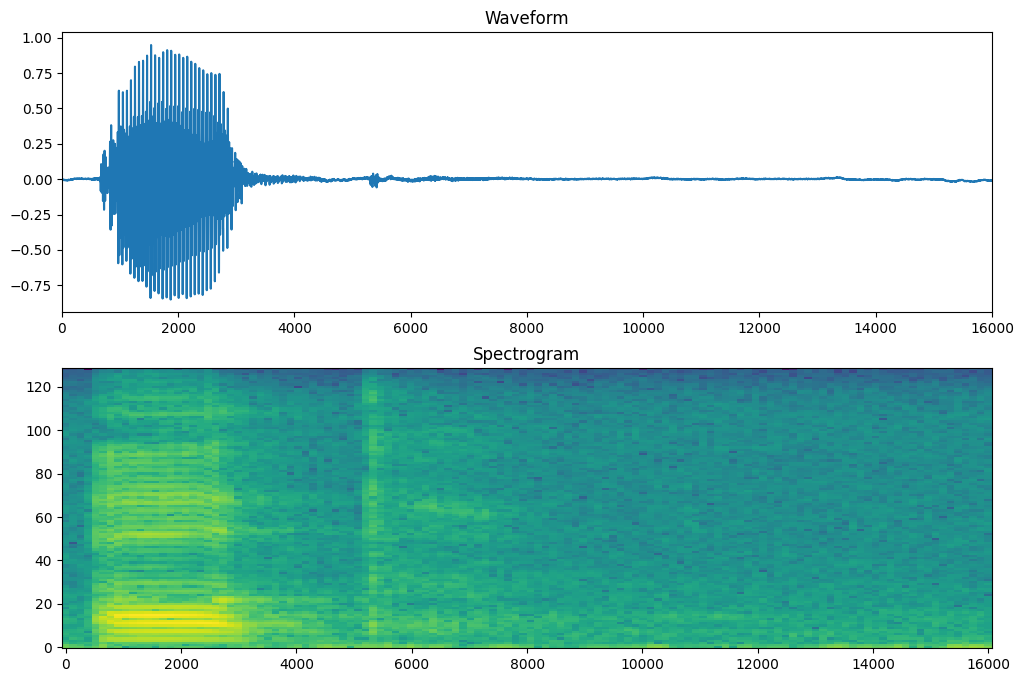

In [16]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.show()

In [17]:
def get_spectrogram_and_label(waveform, label):
    spectrogram = get_spectrogram(waveform)
    return spectrogram, label

In [18]:
spectrogram_train_ds = waveform_train_ds.map(
  map_func=get_spectrogram_and_label,
  num_parallel_calls=AUTOTUNE)

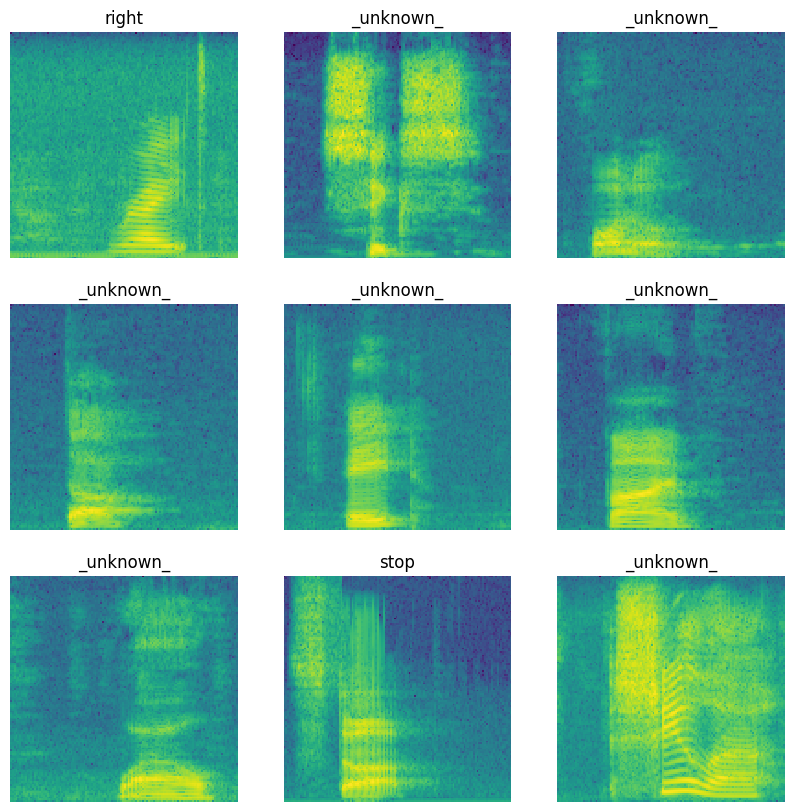

In [19]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 10))

for i, (spectrogram, label) in enumerate(spectrogram_train_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  plot_spectrogram(spectrogram.numpy(), ax)
  ax.set_title(labels[label.numpy()])
  ax.axis('off')

plt.show()

In [20]:
def preprocess_dataset(ds):
    output_ds = ds.map(
        map_func=get_waveform_and_label,
        num_parallel_calls=AUTOTUNE)
    output_ds = output_ds.map(
        map_func=get_spectrogram_and_label,
        num_parallel_calls=AUTOTUNE)
    return output_ds

In [21]:
train_ds = spectrogram_train_ds
val_ds = preprocess_dataset(raw_val_ds)
test_ds = preprocess_dataset(raw_test_ds)

In [22]:
batch_size = 64
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)

In [23]:
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)

In [24]:
for input, _ in spectrogram_train_ds.take(1):
    input_shape = input.shape
    
print('Input shape:', input_shape)

# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
norm_layer.adapt(data=train_ds.map(map_func=lambda s, l: s))

model = models.Sequential([
    layers.Input(shape=input_shape),
    # Downsample the input.
    layers.Resizing(32, 32),
    # Normalize.
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.Conv2D(32, 3, activation='relu'), # added to reduce num of params
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes),
])

model.summary()

Input shape: (124, 129, 1)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 32, 32, 1)         0         
                                                                 
 normalization (Normalizatio  (None, 32, 32, 1)        3         
 n)                                                              
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 conv2d_2 (Conv2D)           (None, 26, 26, 32)        18464     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                           

In [25]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [26]:
EPOCHS = 20
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/20
1337/1337 [==============================] - 10s 6ms/step - loss: 0.8511 - accuracy: 0.7351 - val_loss: 0.4444 - val_accuracy: 0.8554
Epoch 2/20
1337/1337 [==============================] - 7s 6ms/step - loss: 0.5009 - accuracy: 0.8376 - val_loss: 0.3485 - val_accuracy: 0.8853
Epoch 3/20
1337/1337 [==============================] - 7s 6ms/step - loss: 0.4071 - accuracy: 0.8664 - val_loss: 0.2922 - val_accuracy: 0.9063
Epoch 4/20
1337/1337 [==============================] - 7s 6ms/step - loss: 0.3578 - accuracy: 0.8829 - val_loss: 0.2774 - val_accuracy: 0.9125
Epoch 5/20
1337/1337 [==============================] - 7s 6ms/step - loss: 0.3191 - accuracy: 0.8961 - val_loss: 0.2575 - val_accuracy: 0.9202
Epoch 6/20
1337/1337 [==============================] - 7s 6ms/step - loss: 0.2931 - accuracy: 0.9037 - val_loss: 0.2552 - val_accuracy: 0.9225
Epoch 7/20
1337/1337 [==============================] - 7s 5ms/step - loss: 0.2730 - accuracy: 0.9093 - val_loss: 0.2500 - val_accuracy

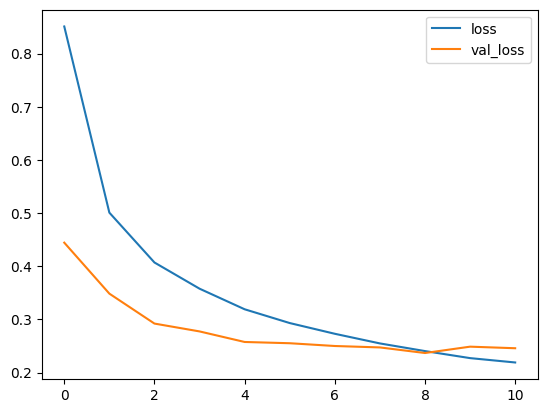

In [27]:
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

In [28]:
test_spectrograms = []
test_labels = []

for spectrogram, label in test_ds:
    test_spectrograms.append(spectrogram.numpy())
    test_labels.append(label.numpy())

test_spectrograms = np.array(test_spectrograms)
test_labels = np.array(test_labels)

In [29]:
y_pred = np.argmax(model.predict(test_spectrograms), axis=1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')

153/153 [==============================] - 0s 2ms/step
Test set accuracy: 86%


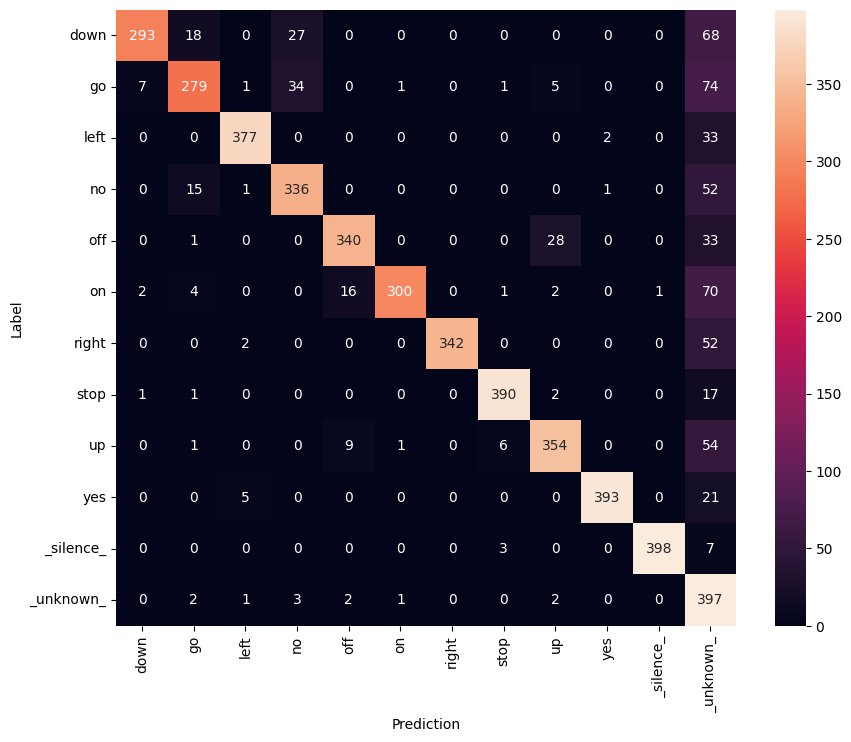

In [30]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=labels,
            yticklabels=labels,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

In [32]:
array_size = 8
examples = 25
output_file = open('speech_commands_input_{0}x{1}.csv'.format(examples, array_size), 'w')

for spectrogram, label in spectrogram_train_ds.take(examples):
    spectrogram = spectrogram[tf.newaxis, ...]
    prediction = model(spectrogram)
    print(f'Expected "{label}", inferred "{tf.math.argmax(prediction[0]).numpy()}"')

    data = spectrogram.numpy()
    for i in range(spectrogram.shape[1]):
        for j in range(spectrogram.shape[2]):
            data[0][i][j].tofile(output_file, sep=",")   
            output_file.write(",")
            np.zeros(array_size - spectrogram.shape[3], dtype='float32').tofile(output_file, sep=",")
            output_file.write("\n")

output_file.close()

Expected "10", inferred "10"
Expected "11", inferred "11"
Expected "11", inferred "11"
Expected "11", inferred "11"
Expected "11", inferred "11"
Expected "11", inferred "11"
Expected "0", inferred "0"
Expected "11", inferred "11"
Expected "11", inferred "11"
Expected "11", inferred "11"
Expected "11", inferred "11"
Expected "3", inferred "3"
Expected "5", inferred "5"
Expected "11", inferred "11"
Expected "0", inferred "0"
Expected "11", inferred "11"
Expected "11", inferred "11"
Expected "11", inferred "11"
Expected "11", inferred "11"
Expected "11", inferred "11"
Expected "5", inferred "5"
Expected "11", inferred "11"
Expected "11", inferred "11"
Expected "11", inferred "11"
Expected "7", inferred "7"


In [33]:
model.save('speech_commands')

INFO:tensorflow:Assets written to: speech_commands/assets


INFO:tensorflow:Assets written to: speech_commands/assets


In [7]:
model = tf.keras.models.load_model('speech_commands')

In [34]:
!python -m tf2onnx.convert --saved-model speech_commands  --output speech_commands.onnx --opset 10 --inputs-as-nchw input_1:0

/usr/lib/python3.8/runpy.py:127: RuntimeWarning: 'tf2onnx.convert' found in sys.modules after import of package 'tf2onnx', but prior to execution of 'tf2onnx.convert'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
2022-06-21 19:31:39,387 - WARNING - '--tag' not specified for saved_model. Using --tag serve
2022-06-21 19:31:39,653 - INFO - Signatures found in model: [serving_default].
2022-06-21 19:31:39,653 - WARNING - '--signature_def' not specified, using first signature: serving_default
2022-06-21 19:31:39,653 - INFO - Output names: ['dense_1']
Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`
2022-06-21 19:31:39,729 - WARNING - From /project/.local/lib/python3.8/site-packages/tf2onnx/tf_loader.py:711: extract_sub_graph (from tensorflow.python.framework.graph_util_impl) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`
2022-06-21 19:31:39,758 - INFO - Usin